# Assignment: Properties of Wound Sealing Powder

## Introduction
In this assignment, we will explore the application of Machine Learning in Pharmaceutical Research and Development (R&D) to predict the properties of a final product, specifically a wound sealing powder used in surgeries. 

The production process involves a batch reactor where the ingredients are mixed, heated, and then cooled. The ingredients remain constant as they are based on a specific formula. All experiments are done in room temperature (35°C).

## Learning Objectives
- Understand data exploration, cleaning, and preprocessing
- Learn to identify and handle logical errors in process data
- Practice feature selection with domain knowledge
- Develop and optimize machine learning models
- Learn to use model predictions for process optimization

## Data Description

- **Sample_Number**
- **Heating_Temperature_C:** Heating temperature during the process (in degrees Celsius).
- **Heating_Duration_min:** Duration for which the mixture is heated (in minutes).
- **Heating_Rate_per_min:** Rate at which the heat is transferred to the fluid (in Kj/min).
- **Cooling_Temperature_C:** Final cooling temperature after the process (in degrees Celsius).
- **Heat_Rejection_Rate_per_min:** Rate at which the heat is rejected during cooling (in Kj/min).
- **Final_Product_Absorption_Capacity:** Measured Absorption capacity of the final wound sealing powder (in ml/g). This is the target variable.
- **Start_Timestamp:** Experiment starting time.
- **End_Timestamp:** Experiment end time.



In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Data Exploration

### Task 1.1: Load and Examine Data

In [9]:
# Load the dataset
df = pd.read_csv('wound_sealing_trial_data.csv')

# Display first few rows
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,Sample_Number,Heating_Temperature_C,Heating_Rate,Cooling_Temperature_C,Heat_Rejection_Rate,Heating_Duration_min,Cooling_Duration_min,Final_Product_Absorption_Capacity,Start_Timestamp,End_Timestamp
0,1,50,120,200.0,1200,44.5,6.250,37,3/7/2025 9:28,55:49.0
1,2,50,120,20.0,3600,44.5,2.083,47,3/8/2025 8:07,28:10.8
2,3,50,120,20.0,6000,44.5,1.250,53,3/9/2025 10:20,07:40.0
3,4,50,120,35.0,1200,44.5,3.125,35,3/10/2025 7:18,11:06.4
4,5,50,120,NaN,1200,44.5,0.000,30,3/13/2025 8:21,01:10.2


In [10]:
# Display basic information
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Sample_Number                      160 non-null    int64  
 1   Heating_Temperature_C              160 non-null    int64  
 2   Heating_Rate                       160 non-null    int64  
 3   Cooling_Temperature_C              144 non-null    float64
 4   Heat_Rejection_Rate                160 non-null    int64  
 5   Heating_Duration_min               160 non-null    float64
 6   Cooling_Duration_min               160 non-null    float64
 7   Final_Product_Absorption_Capacity  160 non-null    int64  
 8   Start_Timestamp                    160 non-null    object 
 9   End_Timestamp                      160 non-null    object 
dtypes: float64(3), int64(5), object(2)
memory usage: 12.6+ KB


In [11]:
# Display summary statistics
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,Sample_Number,Heating_Temperature_C,Heating_Rate,Cooling_Temperature_C,Heat_Rejection_Rate,Heating_Duration_min,Cooling_Duration_min,Final_Product_Absorption_Capacity
count,160.000000,160.000000,160.000000,144.000000,160.00000,160.000000,160.000000,160.000000
mean,80.500000,99.531250,357.000000,47.604167,3405.00000,91.975544,7.018663,51.131250
std,46.332134,35.849076,175.795765,64.417695,2267.62281,87.098775,6.977018,13.434267
min,1.000000,50.000000,120.000000,20.000000,-6000.00000,8.900000,0.000000,29.000000
25%,40.750000,75.000000,280.000000,20.000000,1200.00000,32.364000,2.083000,41.000000
50%,80.500000,100.000000,280.000000,35.000000,3600.00000,60.816500,4.514000,49.000000
75%,120.250000,125.000000,440.000000,50.000000,6000.00000,115.488500,9.028000,60.250000
max,160.000000,150.000000,600.000000,500.000000,6000.00000,341.167000,27.083000,83.000000


### Task 1.2: Data Visualization

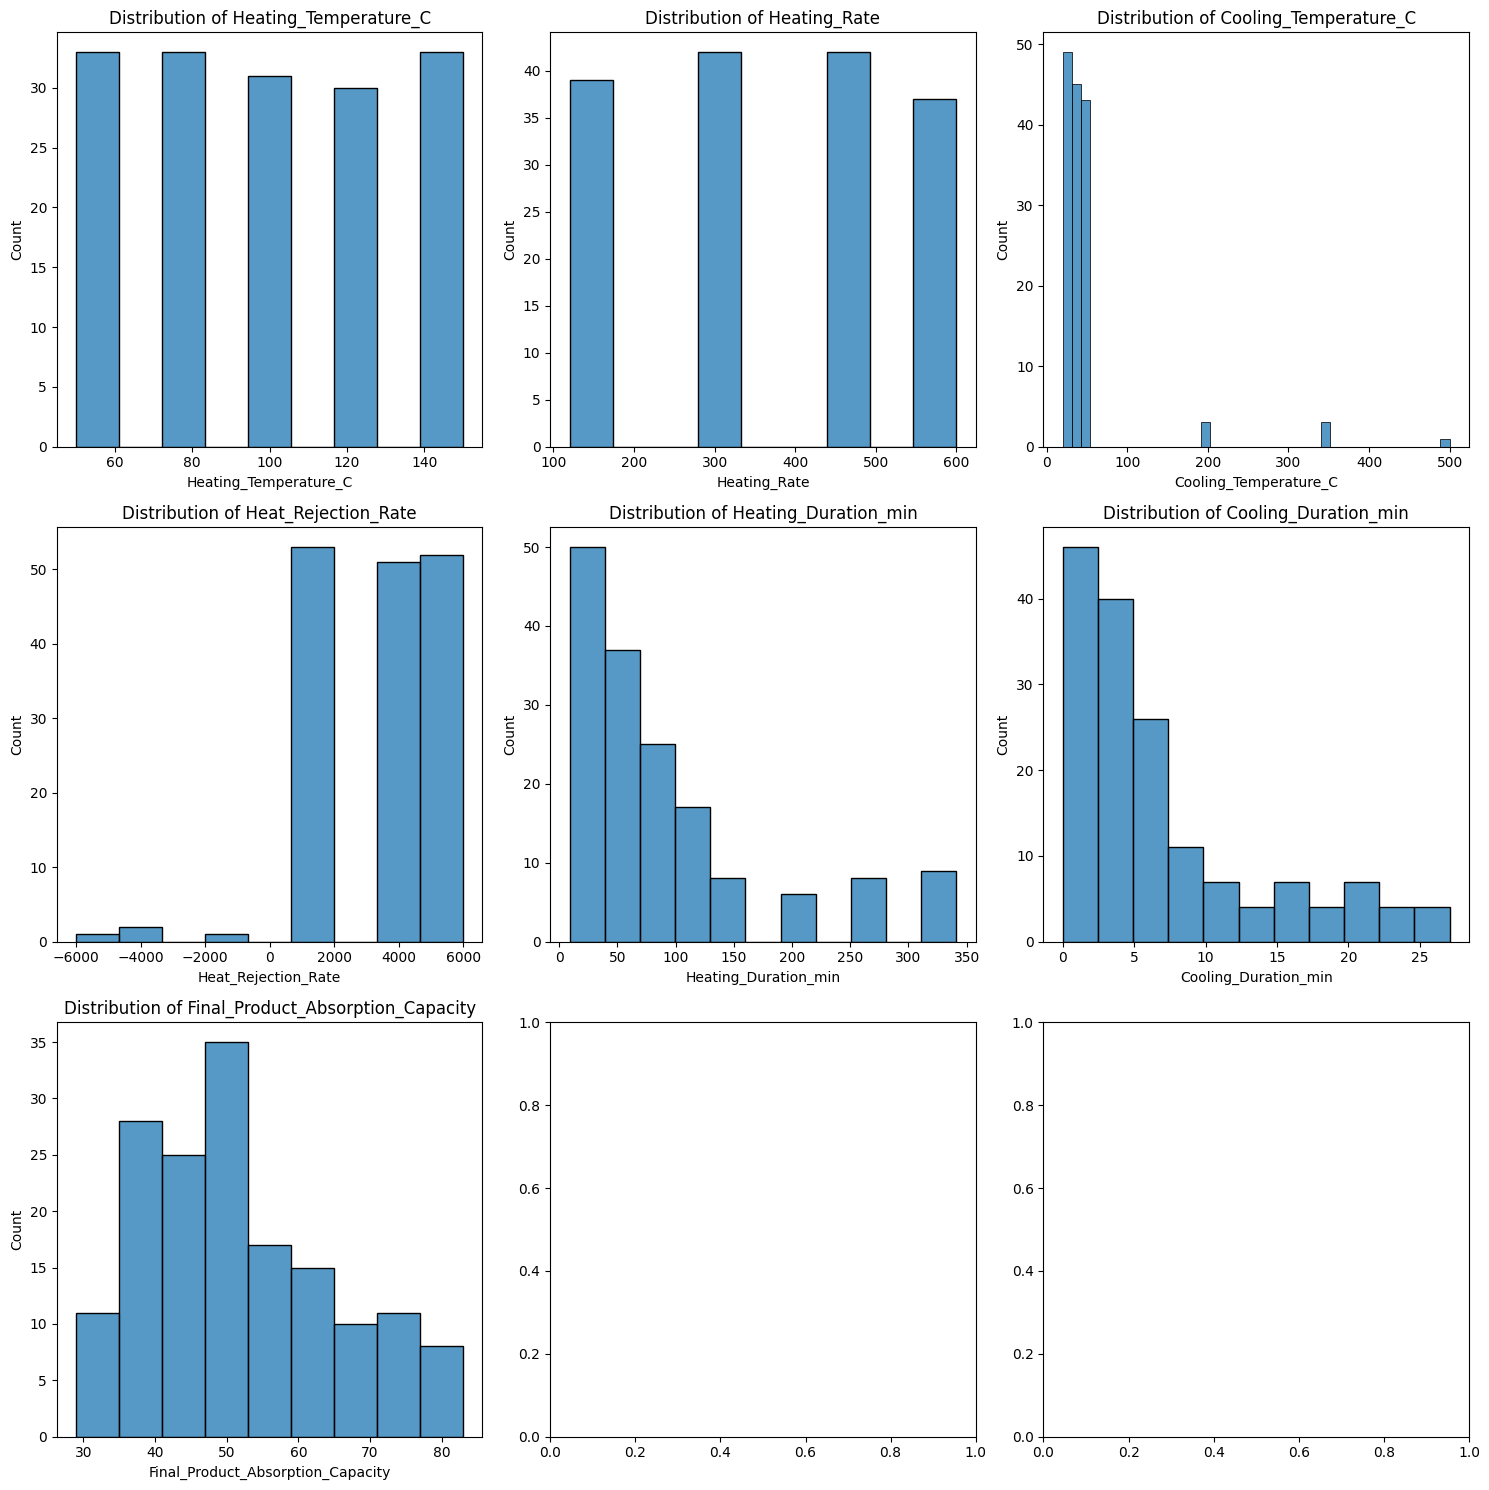

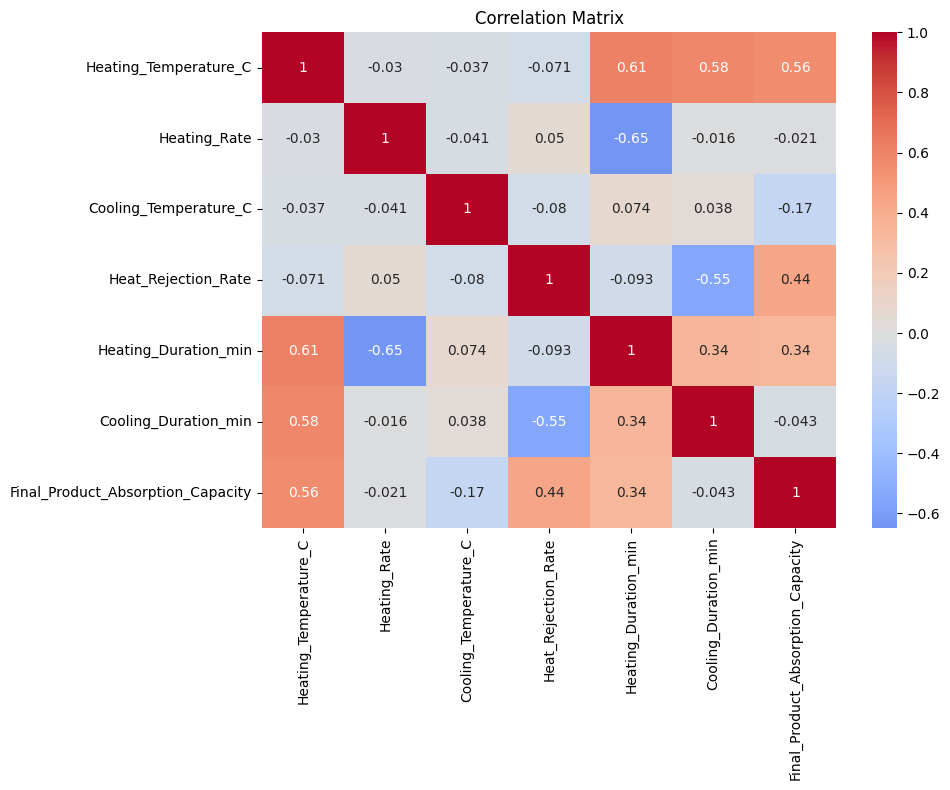

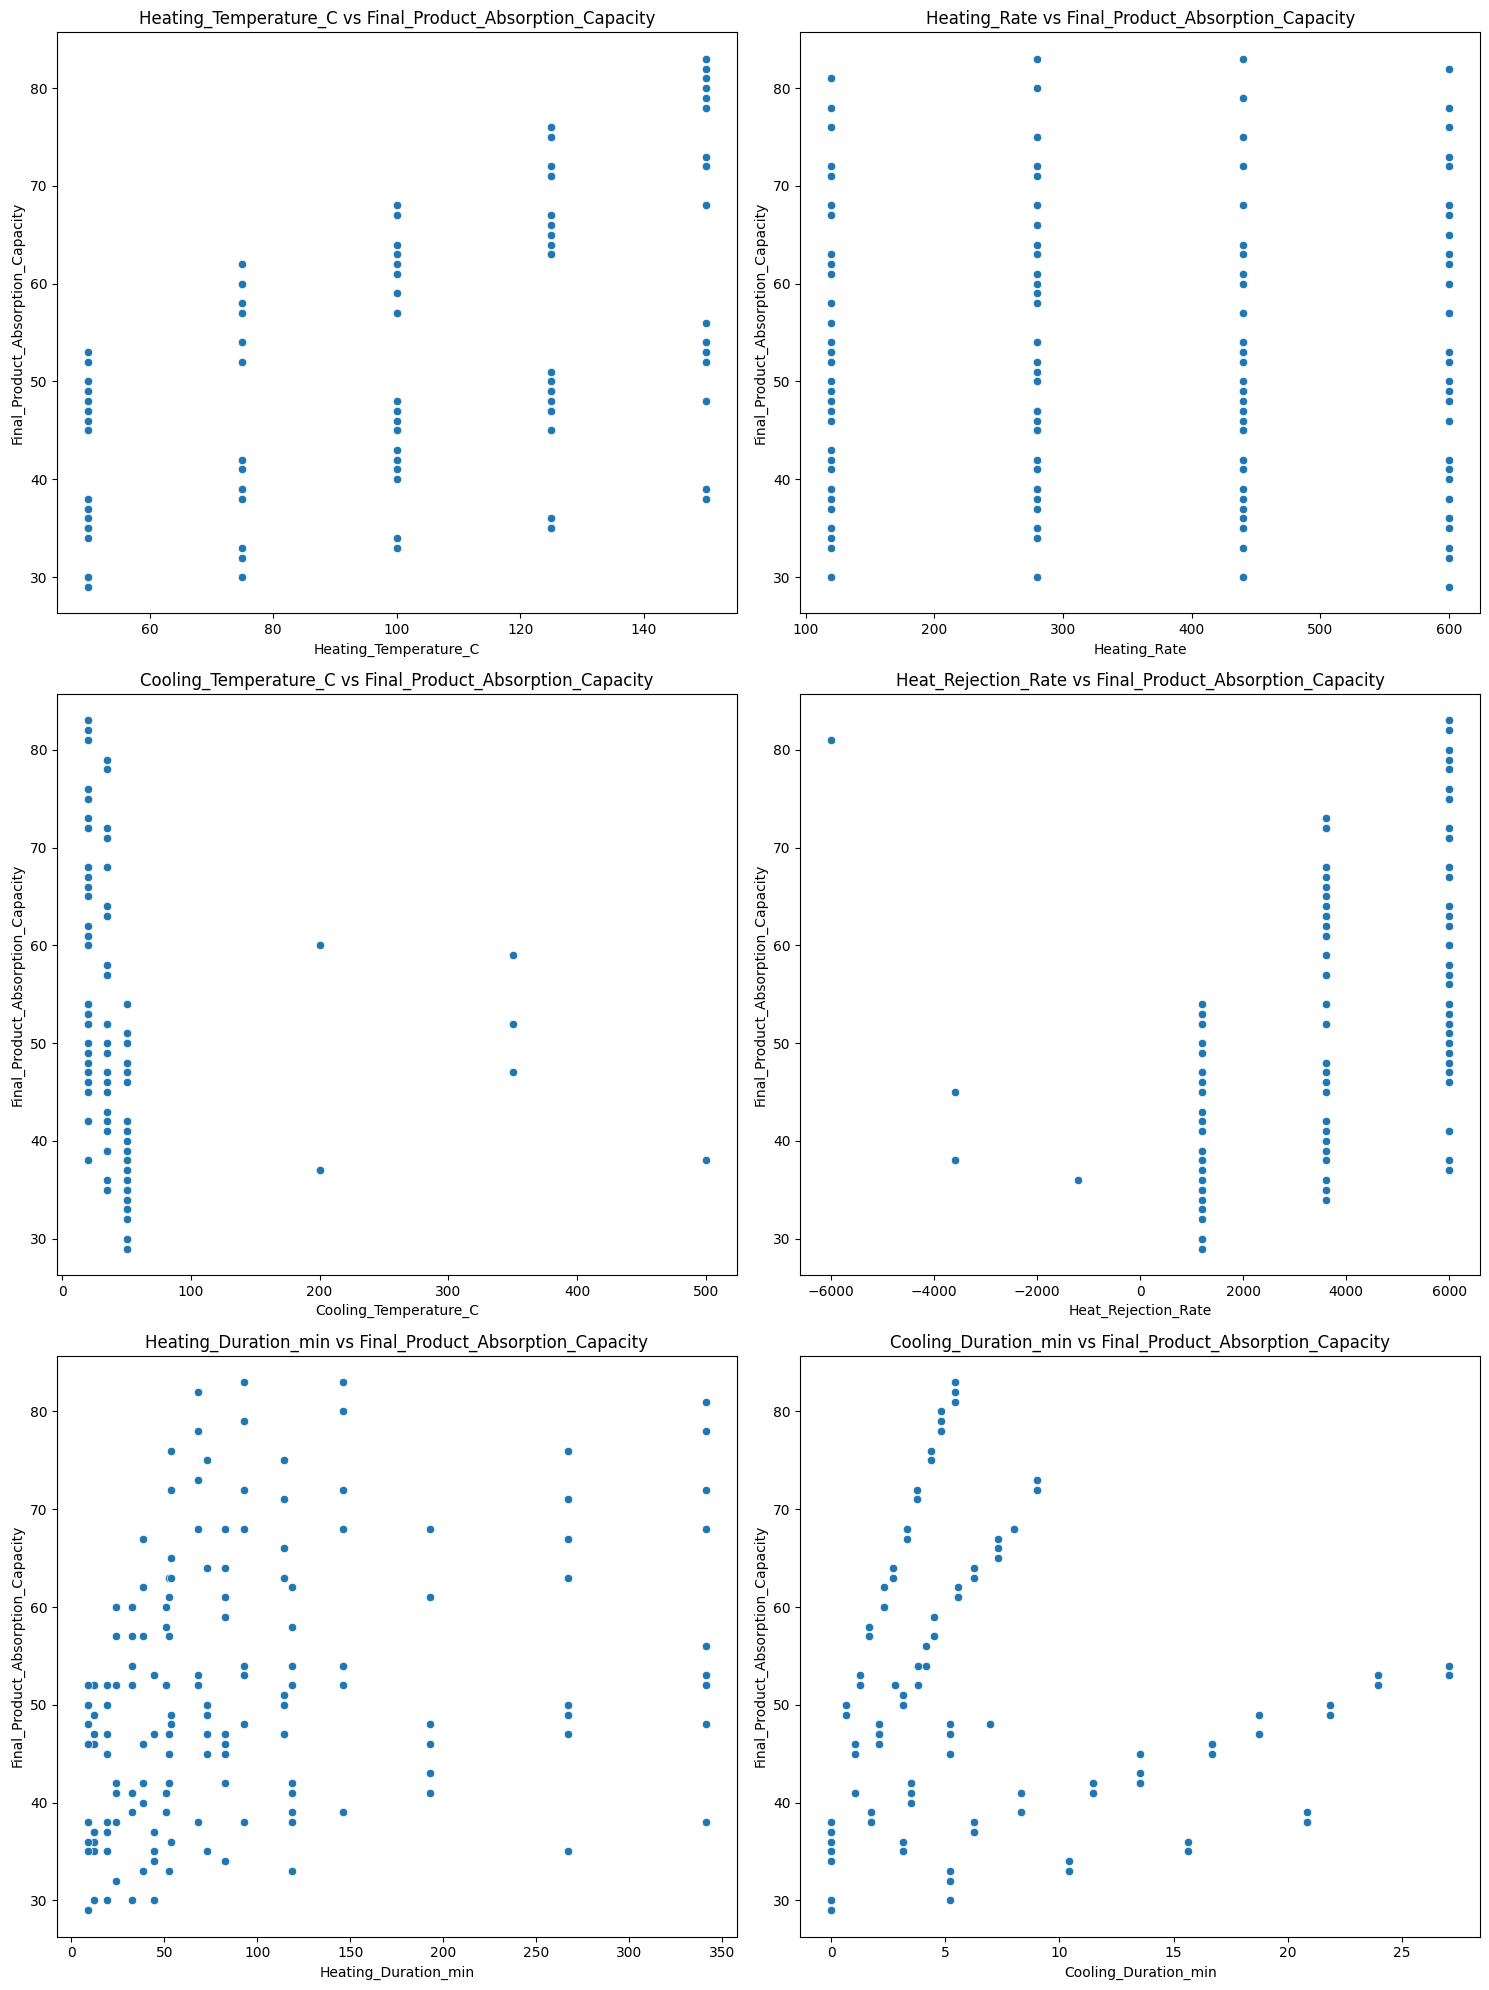

In [12]:
def plot_feature_distributions(df):
    """Plot histograms for all numerical features"""
    # Remove unnecessary features
    
    num_features = len(df.columns)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for idx, col in enumerate(df.columns):
        if idx < len(axes):
            sns.histplot(data=df, x=col, ax=axes[idx])
            axes[idx].set_title(f'Distribution of {col}')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """Plot correlation matrix heatmap"""
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

def plot_feature_relationships(df, target='Final_Product_Absorption_Capacity'):
    """Plot relationships between features and target"""

    features = [col for col in df.columns if col != target]
    n_features = len(features)
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()
    
    for idx, feature in enumerate(features):
        if idx < len(axes):
            sns.scatterplot(data=df, x=feature, y=target, ax=axes[idx])
            axes[idx].set_title(f'{feature} vs {target}')
    
    plt.tight_layout()
    plt.show()

# Prepare df for data visualization by dropping irrelevant features
# TODO
df = df.drop(columns=['Sample_Number', 'Start_Timestamp', 'End_Timestamp'])

plot_feature_distributions(df)
plot_correlation_matrix(df)
plot_feature_relationships(df)

## Part 2: Data Cleaning and Logical Error Handling

### Task 2.1: Identify and Handle Logical Errors

Develop two functions, one to identify logical errors, and another one to fix them.


In [13]:
def check_logical_errors(df):
    """Check for logical errors in the data"""
    errors = {
        'cooling_temp_higher': df['Cooling_Temperature_C'] > df['Heating_Temperature_C'],
        'negative_heating_rate': df['Heating_Rate'] < 0,
        'negative_heat_rejection_rate': df['Heat_Rejection_Rate'] < 0,
    }
    
    print("Logical Errors Found:")
    for error_type, mask in errors.items():
        print(f"{error_type}: {mask.sum()} instances")
    
    return errors

def fix_logical_errors(df):
    """Fix logical errors in the data"""
    # Create a copy of the dataframe to avoid modifying the original
    df_clean = df.copy()
    
    # Fix negative heating rate by making them positive
    mask = df_clean['Heating_Rate'] < 0
    df_clean.loc[mask, 'Heating_Rate'] = df_clean.loc[mask, 'Heating_Rate'].abs()
    
    # Fix negative heat rejection rate by making them positive
    mask = df_clean['Heat_Rejection_Rate'] < 0
    df_clean.loc[mask, 'Heat_Rejection_Rate'] = df_clean.loc[mask, 'Heat_Rejection_Rate'].abs()
    
    # For cooling temperature higher than heating, set cooling temperature to null
    mask = df_clean['Cooling_Temperature_C'] > df_clean['Heating_Temperature_C']
    df_clean.loc[mask, 'Cooling_Temperature_C'] = None
    
    return df_clean

# Check for logical errors
errors = check_logical_errors(df)

# Fix logical errors
df_clean = fix_logical_errors(df)

# Verify fixes
print("\nAfter fixing logical errors:")
check_logical_errors(df_clean)

Logical Errors Found:
cooling_temp_higher: 7 instances
negative_heating_rate: 0 instances
negative_heat_rejection_rate: 4 instances

After fixing logical errors:
Logical Errors Found:
cooling_temp_higher: 0 instances
negative_heating_rate: 0 instances
negative_heat_rejection_rate: 0 instances


{'cooling_temp_higher': 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 155    False
 156    False
 157    False
 158    False
 159    False
 Length: 160, dtype: bool,
 'negative_heating_rate': 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 155    False
 156    False
 157    False
 158    False
 159    False
 Name: Heating_Rate, Length: 160, dtype: bool,
 'negative_heat_rejection_rate': 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 155    False
 156    False
 157    False
 158    False
 159    False
 Name: Heat_Rejection_Rate, Length: 160, dtype: bool}

### Task 2.2: Handle Missing Values and Outliers

#### Missing Value Imputation Hint:
 
For missing cooling temperatures, we can use the heat equation:
 
$Q = m \cdot C_p \cdot \Delta T$
 
Where:
- $Q$ is the heat energy (related to Heat_Rejection_Rate × Cooling_Duration)
- $m$ is the mass (constant for each sample)
- $C_p$ is the specific heat capacity
- $\Delta T$ is the temperature difference $(T_{heating} - T_{cooling})$

Rearranging to solve for the cooling temperature:

$T_{cooling} = T_{heating} - \frac{Q}{m \cdot C_p}$
 
This physical relationship can guide our imputation strategy for missing cooling temperatures.



In [16]:
# Calculate heat capacity using the physical relationship
# Heat capacity = (Heat Rejection Rate * Cooling Duration) / (Temperature difference)
df_clean['Heat_Capacity'] = (df_clean['Heat_Rejection_Rate'] * df_clean['Cooling_Duration_min']) / (df_clean['Heating_Temperature_C'] - df_clean['Cooling_Temperature_C'])

# Check for any invalid values (infinity or NaN) that might result from division
invalid_heat_capacity = df_clean['Heat_Capacity'].isin([np.inf, -np.inf]) | df_clean['Heat_Capacity'].isna()
print(f"Number of invalid heat capacity values: {invalid_heat_capacity.sum()}")

# Calculate statistics for the valid heat capacity values
valid_heat_capacity = df_clean['Heat_Capacity'][~invalid_heat_capacity]

print("\nHeat Capacity Statistics:")
print(f"Mean: {valid_heat_capacity.mean():.4f}")
print(f"Median: {valid_heat_capacity.median():.4f}")
print(f"Mode: {valid_heat_capacity.mode().iloc[0]:.4f}")


Number of invalid heat capacity values: 34

Heat Capacity Statistics:
Mean: 250.0029
Median: 250.0000
Mode: 250.0000


In [24]:
df_clean['Heat_Capacity'].fillna(df_clean['Heat_Capacity'].median(), inplace=True)
df_clean['Heat_Capacity']

0      250.000000
1      249.960000
2      250.000000
3      250.000000
4      250.000000
          ...    
155    250.015385
156    250.000000
157    249.996522
158    250.017391
159    249.996000
Name: Heat_Capacity, Length: 160, dtype: float64

In [25]:
def handle_missing_values(df):
    """Handle missing values in the dataset"""
    print("Missing values before handling:")
    display(df.isnull().sum())

    # Implement logic for handling missing values
    # First, handle missing cooling temperatures using physical relationship
    cooling_temp_missing = df['Cooling_Temperature_C'].isna()
    if cooling_temp_missing.sum() > 0:
        print(f"Imputing {cooling_temp_missing.sum()} missing cooling temperatures using physical relationship")
        
        # Calculate missing cooling temperatures using the formula:
        # Tcooling = Theating - (Heat Rejection Rate * Cooling Duration) / (Heat Capacity)
        df.loc[cooling_temp_missing, 'Cooling_Temperature_C'] = (
            df.loc[cooling_temp_missing, 'Heating_Temperature_C'] - 
            (df.loc[cooling_temp_missing, 'Heat_Rejection_Rate'] * 
             df.loc[cooling_temp_missing, 'Cooling_Duration_min']) / 
            df.loc[cooling_temp_missing, 'Heat_Capacity']
        )
        
    # For any remaining missing values in other columns, use median imputation
    for column in df.columns:
        missing = df[column].isna().sum()
        if missing > 0:
            print(f"Imputing {missing} missing values in {column} using median")
            df[column].fillna(df[column].median(), inplace=True)

    
    print("\nMissing values after handling:")
    display(df_clean.isnull().sum())
    
    return df_clean


# Handle missing values
df_clean = handle_missing_values(df_clean)

# Display summary of cleaned data
print("\nSummary of cleaned data:")
display(df_clean.describe())

Missing values before handling:


Heating_Temperature_C                 0
Heating_Rate                          0
Cooling_Temperature_C                23
Heat_Rejection_Rate                   0
Heating_Duration_min                  0
Cooling_Duration_min                  0
Final_Product_Absorption_Capacity     0
Heat_Capacity                         0
dtype: int64

Imputing 23 missing cooling temperatures using physical relationship

Missing values after handling:


Heating_Temperature_C                0
Heating_Rate                         0
Cooling_Temperature_C                0
Heat_Rejection_Rate                  0
Heating_Duration_min                 0
Cooling_Duration_min                 0
Final_Product_Absorption_Capacity    0
Heat_Capacity                        0
dtype: int64


Summary of cleaned data:


,Heating_Temperature_C,Heating_Rate,Cooling_Temperature_C,Heat_Rejection_Rate,Heating_Duration_min,Cooling_Duration_min,Final_Product_Absorption_Capacity,Heat_Capacity
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,99.531250,357.000000,34.624950,3585.000000,91.975544,7.018663,51.131250,250.002251
std,35.849076,175.795765,12.356774,1968.755952,87.098775,6.977018,13.434267,0.022389
min,50.000000,120.000000,19.992000,1200.000000,8.900000,0.000000,29.000000,249.960000
25%,75.000000,280.000000,20.000000,1200.000000,32.364000,2.083000,41.000000,249.996522
50%,100.000000,280.000000,35.000000,3600.000000,60.816500,4.514000,49.000000,250.000000
75%,125.000000,440.000000,50.000000,6000.000000,115.488500,9.028000,60.250000,250.006154
max,150.000000,600.000000,50.004800,6000.000000,341.167000,27.083000,83.000000,250.080000


## Part 3: Feature Selection and Engineering

### Task 3.1: Feature Analysis

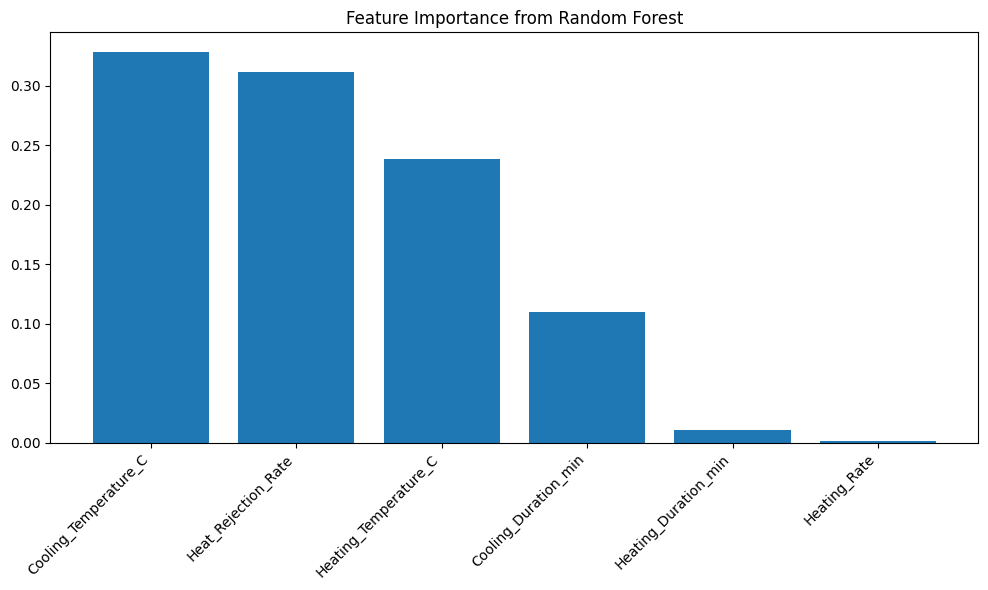

In [28]:
def analyze_feature_importance(X, y):
    """Analyze feature importance using multiple methods"""
    # TODO
    # Use Random Forest for feature importance
    from sklearn.ensemble import RandomForestRegressor
    
    # Initialize and fit random forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance scores
    importance_scores = rf.feature_importances_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_scores
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance from Random Forest')
    plt.tight_layout()
    plt.show()
    return importance_df

# Prepare features and target
X = df_clean.drop(['Final_Product_Absorption_Capacity', 'Heat_Capacity'], axis=1)
y = df_clean['Final_Product_Absorption_Capacity']

# Analyze feature importance
importance_df = analyze_feature_importance(X, y)

### Task 3.2: Feature Engineering (Optional)

Create engineered features as needed. After creating engineered features, fun the feature importance function you developed earlier to evaluate their importance.

In [ ]:
def engineer_features(X):
    """Create engineered features"""
    # TODO
    
    return X_engineered

# Engineer features
X_engineered = engineer_features(X)

# Analyze importance of engineered features
importance_df_engineered = analyze_feature_importance(X_engineered, y)

### Task 3.3: Feature Selection

Select the relevant features that you want to include for model training.

In [31]:
# Select top features based on importance
# TODO
top_features = importance_df.sort_values('Importance', ascending=False)['Feature'].tolist()
X_selected = X[['Cooling_Temperature_C', 'Heat_Rejection_Rate', 'Heating_Temperature_C']]

print("Selected features:")
print(top_features)

Selected features:
['Cooling_Temperature_C', 'Heat_Rejection_Rate', 'Heating_Temperature_C', 'Cooling_Duration_min', 'Heating_Duration_min', 'Heating_Rate']


## Part 4: Model Development and Training

### Task 4.1: Data Preparation and Model Setup

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize your model
# TODO
model = SVR(kernel='rbf')

# Define parameter grid for optimization
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

### Task 4.2: Model Training and Evaluation

In [33]:
def train_and_evaluate_model(grid_search, X_train_scaled, X_test_scaled, y_train, y_test):
    """Train model and evaluate performance"""
    # Fit model
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    metrics = {
        'train': {
            'r2': r2_score(y_train, y_pred_train),
            'rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'mae': mean_absolute_error(y_train, y_pred_train)
        },
        'test': {
            'r2': r2_score(y_test, y_pred_test),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae': mean_absolute_error(y_test, y_pred_test)
        }
    }
    
    # Print results
    print("Best parameters:", grid_search.best_params_)
    print("\nModel Performance:")
    for dataset in ['train', 'test']:
        print(f"\n{dataset.capitalize()} Set:")
        print(f"R² Score: {metrics[dataset]['r2']:.4f}")
        print(f"RMSE: {metrics[dataset]['rmse']:.4f}")
        print(f"MAE: {metrics[dataset]['mae']:.4f}")
    
    return best_model, metrics, y_pred_train, y_pred_test

# Train and evaluate model
best_model, metrics, y_pred_train, y_pred_test = train_and_evaluate_model(
    grid_search, X_train_scaled, X_test_scaled, y_train, y_test
)

Best parameters: {'C': 100, 'epsilon': 0.3, 'gamma': 0.1}

Model Performance:

Train Set:
R² Score: 0.9964
RMSE: 0.8196
MAE: 0.6211

Test Set:
R² Score: 0.9959
RMSE: 0.7862
MAE: 0.5888


### Task 4.3: Model Visualization and Analysis

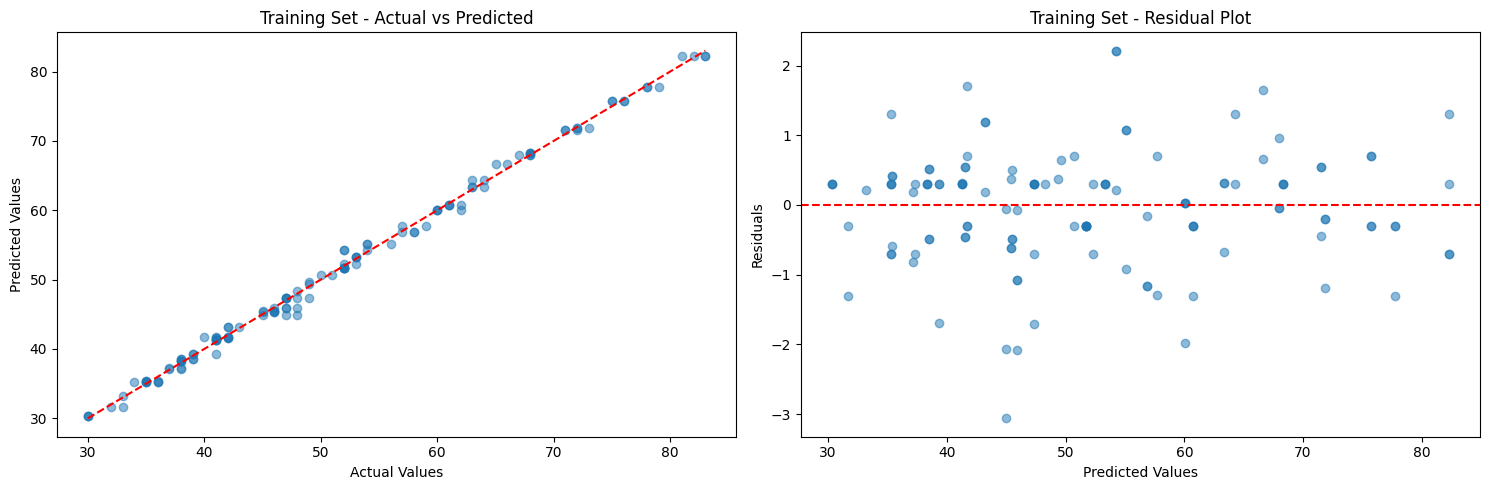

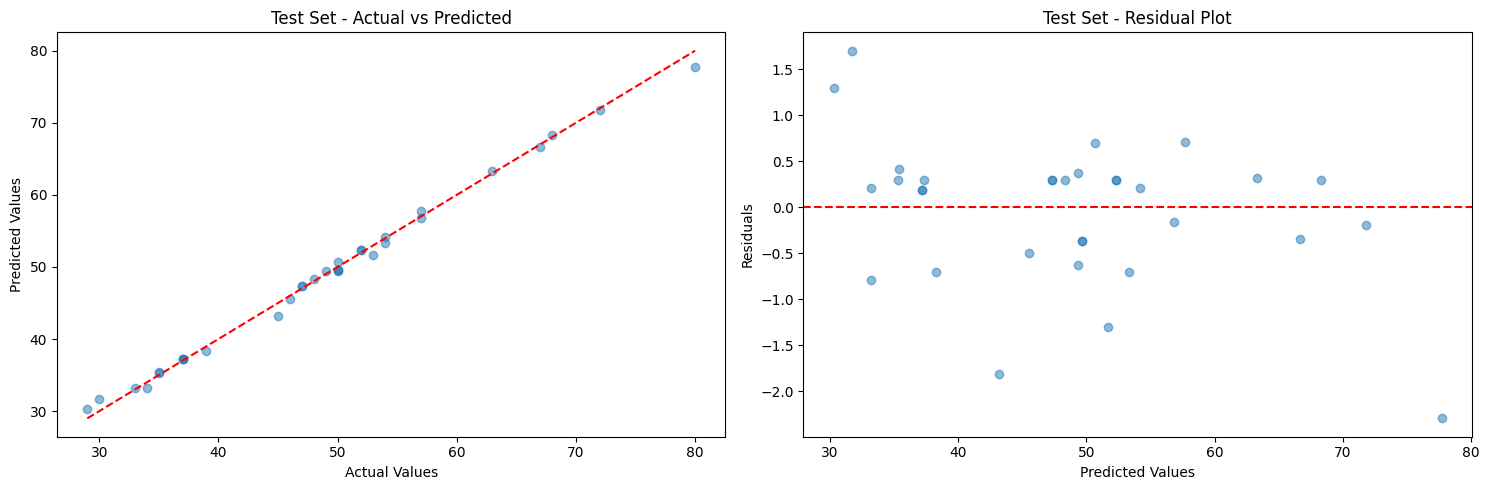

In [34]:
def plot_prediction_analysis(y_true, y_pred, title):
    """Create detailed prediction analysis plots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Actual vs Predicted
    ax1.scatter(y_true, y_pred, alpha=0.5)
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'{title} - Actual vs Predicted')
    
    # Residuals
    residuals = y_pred - y_true
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{title} - Residual Plot')
    
    plt.tight_layout()
    plt.show()

# Plot training set results
plot_prediction_analysis(y_train, y_pred_train, 'Training Set')

# Plot test set results
plot_prediction_analysis(y_test, y_pred_test, 'Test Set')


Test Trial Data Metrics:
R² Score: 0.8697
RMSE: 3.2732
MAE: 2.4798


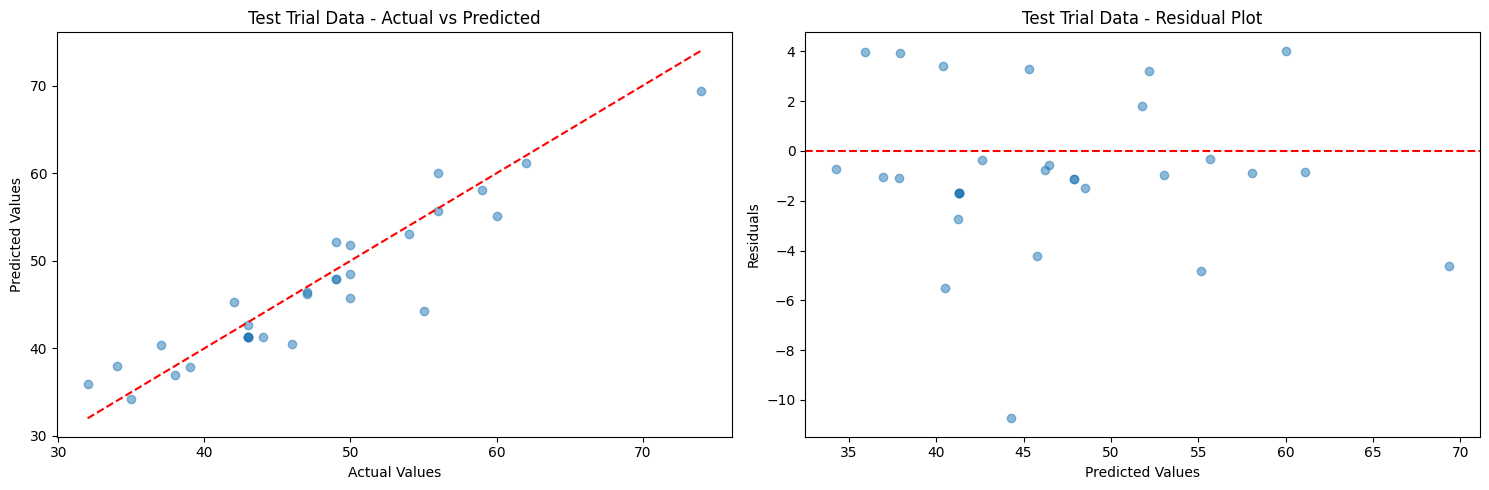

In [35]:
# Load and preprocess test trial data
test_trial_data = pd.read_csv('test_wound_sealing_trial_data.csv')

# Extract features using only the selected features from training
X_test_trial = test_trial_data[X_selected.columns]
y_test_trial = test_trial_data['Final_Product_Absorption_Capacity']

# Scale the features using the same scaler
X_test_trial_scaled = scaler.transform(X_test_trial)

# Make predictions
y_pred_trial = best_model.predict(X_test_trial_scaled)

# Calculate metrics
trial_metrics = {
    'r2': r2_score(y_test_trial, y_pred_trial),
    'rmse': np.sqrt(mean_squared_error(y_test_trial, y_pred_trial)),
    'mae': mean_absolute_error(y_test_trial, y_pred_trial)
}

# Print metrics
print("\nTest Trial Data Metrics:")
print(f"R² Score: {trial_metrics['r2']:.4f}")
print(f"RMSE: {trial_metrics['rmse']:.4f}")
print(f"MAE: {trial_metrics['mae']:.4f}")

# Plot prediction analysis for test trial data
plot_prediction_analysis(y_test_trial, y_pred_trial, 'Test Trial Data')



## Part 5: Process Parameter Optimization (Bonus)

Using the model you developed, figure out what parameters should the reasearches try next.


Optimal Process Parameters:
--------------------------------------------------
Heating_Temperature_C: 190.00
Cooling_Temperature_C: 25.00
Heat_Rejection_Rate: 6600.00

Predicted Absorption Capacity: 87.73


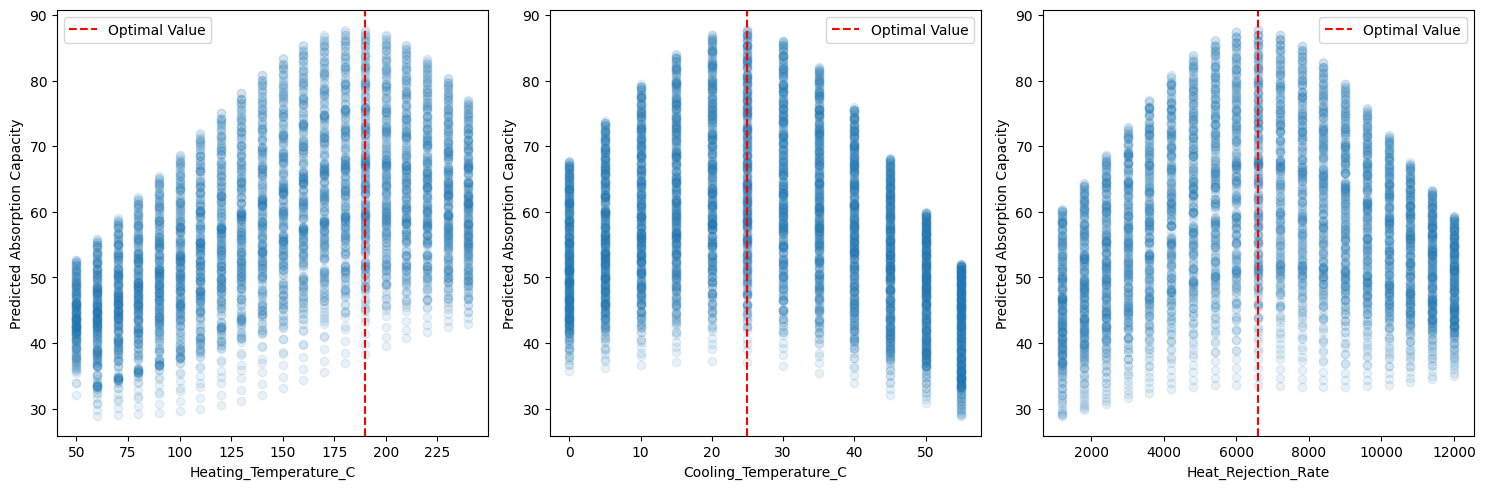

In [ ]:
# Define parameter ranges based on the training data
param_ranges = {
    'Heating_Temperature_C': np.arange(50, 250, 10),  # 50-250°C in steps of 10
    'Cooling_Temperature_C': np.arange(0, 50, 5),  # 0-50°C in steps of 5
    'Heat_Rejection_Rate': np.arange(1200, 12001, 600)  # 1200-12000 in steps of 600
}

# Create a grid of all possible combinations
param_combinations = []
for heating_temp in param_ranges['Heating_Temperature_C']:
    for cooling_temp in param_ranges['Cooling_Temperature_C']:
        for heat_rejection in param_ranges['Heat_Rejection_Rate']:
            # Skip invalid combinations where cooling temp > heating temp
            if cooling_temp >= heating_temp:
                continue
            param_combinations.append([
                heating_temp,
                cooling_temp,
                heat_rejection
            ])

# Convert to DataFrame with proper column names
param_combinations_df = pd.DataFrame(param_combinations, 
                                   columns=['Heating_Temperature_C', 
                                          'Cooling_Temperature_C',
                                          'Heat_Rejection_Rate'])

# Create a DataFrame with all the required features in the same order as during training
# First, get a template with all columns from X_selected
full_features_df = pd.DataFrame(columns=X_selected.columns)

# Then add our parameter combinations, ensuring columns match exactly
for col in param_combinations_df.columns:
    if col in full_features_df.columns:
        full_features_df[col] = param_combinations_df[col]

# Fill any missing columns with appropriate values (means from training data)
for col in full_features_df.columns:
    if col not in param_combinations_df.columns:
        full_features_df[col] = X_selected[col].mean()

# Scale the parameters using the same scaler
param_combinations_scaled = scaler.transform(full_features_df)

# Make predictions for all combinations
predictions = best_model.predict(param_combinations_scaled)

# Find the combination that gives maximum absorption capacity
best_idx = np.argmax(predictions)
best_params = param_combinations_df.iloc[best_idx]
best_prediction = predictions[best_idx]

print("\nOptimal Process Parameters:")
print("-" * 50)
for param in ['Heating_Temperature_C', 'Cooling_Temperature_C', 'Heat_Rejection_Rate']:
    print(f"{param}: {best_params[param]:.2f}")
print(f"\nPredicted Absorption Capacity: {best_prediction:.2f}")

# Visualize the impact of each parameter on the predicted absorption capacity
plt.figure(figsize=(15, 5))
for i, param in enumerate(['Heating_Temperature_C', 'Cooling_Temperature_C', 'Heat_Rejection_Rate']):
    plt.subplot(1, 3, i+1)
    plt.scatter(param_combinations_df[param], predictions, alpha=0.1)
    plt.xlabel(param)
    plt.ylabel('Predicted Absorption Capacity')
    plt.axvline(best_params[param], color='r', linestyle='--', label='Optimal Value')
    plt.legend()
plt.tight_layout()
plt.show()

## Explanation and Final Comments

TODO: Edit this cell to add your comments